In [0]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from keras.utils import to_categorical
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
import pandas as pd
from torch.utils.data.dataset import Dataset
from torch.autograd import Variable
import matplotlib.pyplot as plt

TS_LENGTH = 2000
TRAINSPLIT = 652 / 752
VALSPLIT = 100 / 652
RANDOMSTATE = 413
NUM_EPOCHS = 100
BATCH_SIZE = 32

In [0]:
#подключение к файлам на google drive (мы хранили датасет там)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#путь к папке с датасетом
root = 'drive/My Drive/3 курс/data'

#путь к данным, сгенерированным в depresjon_preprocessing.ipynb
condition_path = root + '/condition_time_activity/condition_{}.csv'
control_path = root + '/control_time_activity/control_{}.csv'

#создаем двумерный массив всех записей одного файла вида [[час, активность], ...]
def create_record_arr(x, currPath):
    curr_file = pd.read_csv(currPath.format(x))    
    arr = np.zeros([len(curr_file), 2])
    for i in range(len(curr_file)):
        arr[i] = [curr_file['time'][i], curr_file['activity'][i]]
    return arr

#создаем массивы данных со всеми файлами
condition_raw = [  
    np.array(create_record_arr(x, condition_path))
    for x in range(1, 24)
]
control_raw = [
    np.array(create_record_arr(x, control_path))
    for x in range(1, 33)
]

print("condition_raw:\n")
print(condition_raw)
print("control_raw:\n")
print(control_raw)

condition_raw:

[array([[ 12.,   0.],
       [ 12., 143.],
       [ 12.,   0.],
       ...,
       [ 15.,   0.],
       [ 15.,   0.],
       [ 15., 533.]]), array([[  15., 1468.],
       [  15., 1006.],
       [  15.,  468.],
       ...,
       [  15.,   13.],
       [  15.,    0.],
       [  15.,    0.]]), array([[15.,  7.],
       [15.,  8.],
       [15.,  7.],
       ...,
       [15., 17.],
       [15.,  7.],
       [15.,  7.]]), array([[ 11., 510.],
       [ 12., 637.],
       [ 12., 598.],
       ...,
       [ 11.,   0.],
       [ 11.,   0.],
       [ 11.,   0.]]), array([[ 10.,   0.],
       [ 10.,   0.],
       [ 10.,   0.],
       ...,
       [  8., 390.],
       [  8., 197.],
       [  8.,   0.]]), array([[ 12.,   0.],
       [ 12.,   0.],
       [ 12.,   0.],
       ...,
       [  9.,   0.],
       [  9.,   0.],
       [  9., 666.]]), array([[10.,  5.],
       [10.,  3.],
       [10.,  3.],
       ...,
       [19.,  5.],
       [19., 80.],
       [19.,  0.]]), array([[ 10.,  

In [0]:
# Разделяем данные на семплы длиной 2000 
TS_LENGTH = 2000
truncate = lambda series: series[:TS_LENGTH * (len(series) // TS_LENGTH)]

#объединим данные по всем файлам в 2 массива
condition = np.concatenate(
    [truncate(series).reshape(-1, TS_LENGTH) for series in condition_raw])
control = np.concatenate(
    [truncate(series).reshape(-1, TS_LENGTH) for series in control_raw])


print("Массив condition до масштабирования и нормализации: ")
print(condition)

#масштабируем данные с помощью логарифмирования
control = np.log(control + 1)
condition = np.log(condition + 1)

#нормализуем данные
df_min = 0
df_max = max(control.max(), condition.max())
control = (control - df_min) / (df_max - df_min)
condition = (condition - df_min) / (df_max - df_min)

print("\nМассив condition после масштабирования и нормализации: ")
print(condition)

print("\nСохраняем обработанные данные в файлы")
print("condition_{}".format(TS_LENGTH),"and","control_{}".format(TS_LENGTH))
np.save("condition_{}".format(TS_LENGTH), condition)
np.save("control_{}".format(TS_LENGTH), control)


Массив condition до масштабирования и нормализации: 
[[ 12.   0.  12. ...   0.   4.   0.]
 [  4.   0.   4. ...  38.  21. 568.]
 [ 21. 250.  21. ...   0.  13.   0.]
 ...
 [  7.   0.   7. ...   0.  23.   0.]
 [ 23.   0.  23. ...   0.  16.   0.]
 [ 16.   0.  16. ...   0.   8.   0.]]

Массив condition после масштабирования и нормализации: 
[[0.28539641 0.         0.28539641 ... 0.         0.1790787  0.        ]
 [0.1790787  0.         0.1790787  ... 0.40763664 0.34393366 0.70586995]
 [0.34393366 0.61480528 0.34393366 ... 0.         0.29364224 0.        ]
 ...
 [0.231375   0.         0.231375   ... 0.         0.35361523 0.        ]
 [0.35361523 0.         0.35361523 ... 0.         0.31524557 0.        ]
 [0.31524557 0.         0.31524557 ... 0.         0.24448046 0.        ]]

Сохраняем обработанные данные в файлы
condition_2000 and control_2000


In [0]:
#UMAP embedding для уменьшения размерности данных
from sklearn import manifold
import umap

print("Загружаем подготовленные данные...\n")
condition = np.load("condition_{}.npy".format(TS_LENGTH))
control = np.load("control_{}.npy".format(TS_LENGTH))

print(condition)
print("")
print("UMAP embedding для condition...")
emb_cond = umap.UMAP().fit_transform(condition)
print("UMAP embedding для control...\n")
emb_cont = umap.UMAP().fit_transform(control)

print(emb_cond)

print("\nСохраняем результаты в *_emb.npy")
np.save("condition_{}_emb".format(TS_LENGTH), emb_cond)
np.save("control_{}_emb".format(TS_LENGTH), emb_cont)

Загружаем подготовленные данные...

[[0.28539641 0.         0.28539641 ... 0.         0.1790787  0.        ]
 [0.1790787  0.         0.1790787  ... 0.40763664 0.34393366 0.70586995]
 [0.34393366 0.61480528 0.34393366 ... 0.         0.29364224 0.        ]
 ...
 [0.231375   0.         0.231375   ... 0.         0.35361523 0.        ]
 [0.35361523 0.         0.35361523 ... 0.         0.31524557 0.        ]
 [0.31524557 0.         0.31524557 ... 0.         0.24448046 0.        ]]

UMAP embedding для condition...
UMAP embedding для control...

[[ 8.040348    1.4745107 ]
 [ 5.014101    0.83088833]
 [ 8.680248   -2.1580045 ]
 ...
 [10.195472   -2.8558798 ]
 [ 9.798721   -3.1849296 ]
 [ 9.988603   -2.2011344 ]]

Сохраняем результаты в *_emb.npy


In [0]:
root = os.path.curdir

#Загружаем condition и control, формируем исходные данные для будущей модели
condition = np.load(os.path.join(root, "condition_{}_emb.npy").format(TS_LENGTH))
control = np.load(os.path.join(root, "control_{}_emb.npy").format(TS_LENGTH))
X = np.concatenate((condition, control), axis=0) #исходные данные
y = np.array([0] * len(condition) + [1] * len(control)) #labels: 0 - есть депрессия, 1 - нет депрессии

print(condition)
print(len(condition))
print(len(control))

[[ 8.040348    1.4745107 ]
 [ 5.014101    0.83088833]
 [ 8.680248   -2.1580045 ]
 ...
 [10.195472   -2.8558798 ]
 [ 9.798721   -3.1849296 ]
 [ 9.988603   -2.2011344 ]]
522
982


In [0]:
#делаем разделение на train и test
train_X, test_X, train_y, test_y = train_test_split(
   X, y, test_size=1 - TRAINSPLIT, random_state=RANDOMSTATE)

In [0]:
class GenericDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __getitem__(self, index):
        return (self.X[index], self.y[index])
    
    def __len__(self):
        assert (len(self.X) == len(self.y))
        return len(self.X)

train_dataset = GenericDataset(train_X, train_y)
test_dataset = GenericDataset(test_X, test_y)

In [0]:
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True)

#Определяем нашу модель:

class Net(nn.Module):
    def __init__(self, input_size=2, output_size=2, hidden_dim=4, n_layers=20):
        super(Net, self).__init__()

        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        #Определяем слои сети
        # RNN Layer
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)   
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_size)
    
    def forward(self, x):
        batch_size = x.size(0)

        #Инициализируем hidden state для первого input
        hidden = self.init_hidden(batch_size)

        #Передаем в модель input - x и hidden state, получаем output
        out, hidden = self.rnn(x, hidden)
        
        #Сделаем reshape для output'а чтобы передать его в fully connected layer
        out = out.contiguous().view(-1, self.hidden_dim)
        out = self.fc(out)
        
        return out, hidden
    
    def init_hidden(self, batch_size):
        #Генерируем первый hidden state состоящий из нулей 
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
        return hidden

In [0]:
net = Net()

# loss и optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters())

loss_history = []
epoch_history = []


#начнем обучение модели
for epoch in range(NUM_EPOCHS):
    for i, sample in enumerate(train_loader):
        x, y = sample
        # Forward + Backward + Optimize
        optimizer.zero_grad()
        outputs = net(Variable(x).unsqueeze(1))
        loss = criterion(outputs[0], Variable(y).long())
        loss.backward()
        optimizer.step()

    loss_history.append(float(loss.data))
    epoch_history.append(epoch)
    
    if (epoch + 1) % 10 == 0:
        print('Epoch [%d/%d], Step [%d/%d], Loss: %.4f' %
              (epoch + 1, NUM_EPOCHS, i + 1, len(train_dataset) // BATCH_SIZE,
               loss.data))
        

Epoch [10/100], Step [41/40], Loss: 0.1564
Epoch [20/100], Step [41/40], Loss: 0.0536
Epoch [30/100], Step [41/40], Loss: 0.0610
Epoch [40/100], Step [41/40], Loss: 0.0356
Epoch [50/100], Step [41/40], Loss: 0.1337
Epoch [60/100], Step [41/40], Loss: 0.2191
Epoch [70/100], Step [41/40], Loss: 0.0572
Epoch [80/100], Step [41/40], Loss: 0.0475
Epoch [90/100], Step [41/40], Loss: 0.1322
Epoch [100/100], Step [41/40], Loss: 0.0539


In [0]:
#Сохраним модель
torch.save(net.state_dict(), 'model.pkl')

predict_out = torch.Tensor(test_X)
_, predict_y = torch.max(predict_out, 1)
print('prediction accuracy', accuracy_score(test_y.data, predict_y.data))
print('macro precision',
      precision_score(test_y.data, predict_y.data, average='macro'))
print('micro precision',
      precision_score(test_y.data, predict_y.data, average='micro'))
print('macro recall', recall_score(
    test_y.data, predict_y.data, average='macro'))
print('micro recall', recall_score(
    test_y.data, predict_y.data, average='micro'))

prec = precision_score(test_y.data, predict_y.data, average='macro')
rec = recall_score(test_y.data, predict_y.data, average='macro')
f1 =  2 * ((prec * rec) / (prec + rec))
print('F1 функция', f1)

prediction accuracy 0.925
macro precision 0.9117647058823529
micro precision 0.925
macro recall 0.9423076923076923
micro recall 0.925
F1 функция 0.9267846247712018


[0.7246397137641907, 0.6369190812110901, 0.6633279919624329, 0.6622900366783142, 0.6159968972206116, 0.5457578897476196, 0.2439643293619156, 0.1992460936307907, 0.07756040245294571, 0.1563999503850937, 0.15825311839580536, 0.14060668647289276, 0.23735730350017548, 0.13292472064495087, 0.14576466381549835, 0.23814864456653595, 0.22751237452030182, 0.0683484897017479, 0.2540051341056824, 0.05360378697514534, 0.24424242973327637, 0.13542406260967255, 0.3266458809375763, 0.33484211564064026, 0.14294151961803436, 0.22011548280715942, 0.12811805307865143, 0.2191835194826126, 0.05385442078113556, 0.06102723255753517, 0.2412278652191162, 0.13603051006793976, 0.1590220332145691, 0.30595433712005615, 0.1209208145737648, 0.05036192759871483, 0.07399488240480423, 0.1442013829946518, 0.0634380578994751, 0.035558078438043594, 0.13454164564609528, 0.1488315314054489, 0.12962426245212555, 0.23170284926891327, 0.12916885316371918, 0.11991193145513535, 0.22370074689388275, 0.05769312381744385, 0.0320872

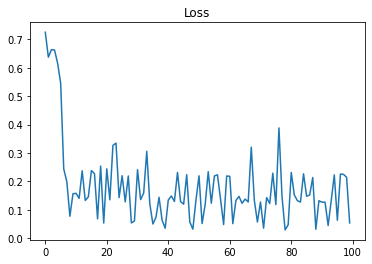

In [0]:
print(loss_history)
print(epoch_history)

plt.title("Loss")
plt.plot(epoch_history, loss_history)


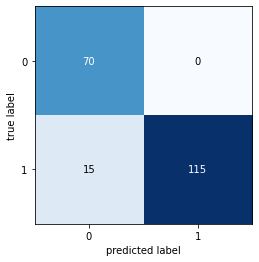

In [0]:
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(test_y.data, predict_y.data)

from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=cnf_matrix)
plt.show()

##labels: 0 - есть депрессия, 1 - нет депрессии